### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_5_2/'
summaries_path = cur_dir + 'summaries_5_2/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 5
    k = 0
    labels_list = list(range(num_class))
    seed = 2
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 19
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/19, validation accuracies: [0.2], average train loss: 1.387488, average train accuracy: 0.471628
epoch: 2, iter: 0/19, validation accuracies: [0.60000002], average train loss: 0.967586, average train accuracy: 0.602796
epoch: 3, iter: 0/19, validation accuracies: [0.72000003], average train loss: 0.911347, average train accuracy: 0.647204
epoch: 4, iter: 0/19, validation accuracies: [0.66000003], average train loss: 0.890863, average train accuracy: 0.652961
epoch: 5, iter: 0/19, validation accuracies: [0.72000003], average train loss: 0.840867, average train accuracy: 0.676809
epoch: 5, iter: 5/19, loss: 0.686001, accuracy: 0.734375
epoch: 6, iter: 0/19, validation accuracies: [0.72000003], average train loss: 0.833683, average train accuracy: 0.682977
epoch: 7, iter: 0/19, validation accuracies: [0.74000001

epoch: 62, iter: 0/19, validation accuracies: [0.93000001], average train loss: 0.074358, average train accuracy: 0.972039
epoch: 63, iter: 0/19, validation accuracies: [0.93000001], average train loss: 0.073929, average train accuracy: 0.971628
epoch: 63, iter: 3/19, loss: 0.038575, accuracy: 0.984375
epoch: 64, iter: 0/19, validation accuracies: [0.93000001], average train loss: 0.067961, average train accuracy: 0.976974
epoch: 65, iter: 0/19, validation accuracies: [0.94], average train loss: 0.058626, average train accuracy: 0.980674
epoch: 66, iter: 0/19, validation accuracies: [0.94], average train loss: 0.059764, average train accuracy: 0.980674
epoch: 67, iter: 0/19, validation accuracies: [0.94], average train loss: 0.058464, average train accuracy: 0.981497
epoch: 68, iter: 0/19, validation accuracies: [0.92000002], average train loss: 0.059556, average train accuracy: 0.979852
epoch: 68, iter: 8/19, loss: 0.020406, accuracy: 0.992188
epoch: 69, iter: 0/19, validation accurac

epoch: 43, iter: 0/19, validation accuracies: [0.81999999 0.75999999], average train loss: 0.415916, average train accuracy: 0.852385
epoch: 44, iter: 0/19, validation accuracies: [0.70999998 0.79000002], average train loss: 0.411745, average train accuracy: 0.856086
epoch: 45, iter: 0/19, validation accuracies: [0.79000002 0.75999999], average train loss: 0.406989, average train accuracy: 0.859786
epoch: 46, iter: 0/19, validation accuracies: [0.81       0.80000001], average train loss: 0.395897, average train accuracy: 0.860197
epoch: 47, iter: 0/19, validation accuracies: [0.81 0.75], average train loss: 0.358953, average train accuracy: 0.870477
epoch: 47, iter: 7/19, loss: 0.375114, accuracy: 0.867188
epoch: 48, iter: 0/19, validation accuracies: [0.83999997 0.77999997], average train loss: 0.352192, average train accuracy: 0.872122
epoch: 49, iter: 0/19, validation accuracies: [0.86000001 0.69      ], average train loss: 0.378567, average train accuracy: 0.870888
epoch: 50, iter:

epoch: 21, iter: 0/19, validation accuracies: [0.70999998 0.69999999 0.60000002], average train loss: 0.863186, average train accuracy: 0.705592
epoch: 21, iter: 1/19, loss: 0.720957, accuracy: 0.718750
epoch: 22, iter: 0/19, validation accuracies: [0.70999998 0.69999999 0.60000002], average train loss: 0.717533, average train accuracy: 0.752467
epoch: 23, iter: 0/19, validation accuracies: [0.72000003 0.74000001 0.56      ], average train loss: 0.761793, average train accuracy: 0.738487
epoch: 24, iter: 0/19, validation accuracies: [0.60000002 0.69       0.69999999], average train loss: 0.733066, average train accuracy: 0.737664
epoch: 25, iter: 0/19, validation accuracies: [0.63       0.70999998 0.63      ], average train loss: 0.730337, average train accuracy: 0.746299
epoch: 26, iter: 0/19, validation accuracies: [0.81999999 0.73000002 0.63      ], average train loss: 0.713579, average train accuracy: 0.747944
epoch: 26, iter: 6/19, loss: 0.680019, accuracy: 0.789062
epoch: 27, ite

time taken: %f 0.6587188243865967
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.14       0.28       0.15000001 0.04      ], average train loss: 3.470919, average train accuracy: 0.172286
epoch: 2, iter: 0/19, validation accuracies: [0.47999999 0.46000001 0.37     

epoch: 46, iter: 0/19, validation accuracies: [0.76999998 0.75       0.68000001 0.56999999], average train loss: 0.605010, average train accuracy: 0.777549
epoch: 47, iter: 0/19, validation accuracies: [0.63999999 0.72000003 0.69999999 0.60000002], average train loss: 0.588356, average train accuracy: 0.786595
epoch: 47, iter: 7/19, loss: 0.578277, accuracy: 0.750000
epoch: 48, iter: 0/19, validation accuracies: [0.70999998 0.80000001 0.64999998 0.63      ], average train loss: 0.573214, average train accuracy: 0.793586
epoch: 49, iter: 0/19, validation accuracies: [0.70999998 0.75999999 0.77999997 0.61000001], average train loss: 0.585105, average train accuracy: 0.780839
epoch: 50, iter: 0/19, validation accuracies: [0.77999997 0.79000002 0.73000002 0.66000003], average train loss: 0.557056, average train accuracy: 0.791941
epoch: 51, iter: 0/19, validation accuracies: [0.76999998 0.79000002 0.75999999 0.69      ], average train loss: 0.461232, average train accuracy: 0.834704
epoch:

epoch: 18, iter: 0/19, validation accuracies: [0.61000001 0.63       0.72000003 0.50999999 0.40000001], average train loss: 0.995482, average train accuracy: 0.596217
epoch: 19, iter: 0/19, validation accuracies: [0.61000001 0.69999999 0.72000003 0.47999999 0.34999999], average train loss: 0.981697, average train accuracy: 0.585938
epoch: 20, iter: 0/19, validation accuracies: [0.69       0.73000002 0.67000002 0.55000001 0.36000001], average train loss: 0.916606, average train accuracy: 0.614720
epoch: 21, iter: 0/19, validation accuracies: [0.68000001 0.67000002 0.62       0.50999999 0.38      ], average train loss: 0.969713, average train accuracy: 0.601562
epoch: 21, iter: 1/19, loss: 1.047355, accuracy: 0.609375
epoch: 22, iter: 0/19, validation accuracies: [0.69999999 0.60000002 0.75999999 0.60000002 0.40000001], average train loss: 1.007861, average train accuracy: 0.600329
epoch: 23, iter: 0/19, validation accuracies: [0.70999998 0.62       0.69       0.52999997 0.47      ], ave

epoch: 64, iter: 0/19, validation accuracies: [0.77999997 0.72000003 0.81       0.69       0.44999999], average train loss: 0.560288, average train accuracy: 0.749589
epoch: 65, iter: 0/19, validation accuracies: [0.77999997 0.72000003 0.80000001 0.69       0.44      ], average train loss: 0.486718, average train accuracy: 0.770559
epoch: 66, iter: 0/19, validation accuracies: [0.77999997 0.74000001 0.81       0.68000001 0.44999999], average train loss: 0.532961, average train accuracy: 0.766447
epoch: 67, iter: 0/19, validation accuracies: [0.76999998 0.74000001 0.81       0.68000001 0.46000001], average train loss: 0.507797, average train accuracy: 0.765625
epoch: 68, iter: 0/19, validation accuracies: [0.76999998 0.73000002 0.81       0.68000001 0.44      ], average train loss: 0.551381, average train accuracy: 0.758635
epoch: 68, iter: 8/19, loss: 0.640706, accuracy: 0.781250
epoch: 69, iter: 0/19, validation accuracies: [0.75999999 0.73000002 0.81999999 0.66000003 0.44      ], ave

epoch: 31, iter: 11/19, loss: 1.082355, accuracy: 0.632812
epoch: 32, iter: 0/19, validation accuracies: [0.77999997 0.61000001 0.63       0.63999999 0.47       0.41999999], average train loss: 0.945183, average train accuracy: 0.647204
epoch: 33, iter: 0/19, validation accuracies: [0.72000003 0.67000002 0.68000001 0.56       0.41       0.47999999], average train loss: 0.959278, average train accuracy: 0.620888
epoch: 34, iter: 0/19, validation accuracies: [0.63999999 0.63999999 0.56999999 0.64999998 0.41       0.63999999], average train loss: 0.922766, average train accuracy: 0.648026
epoch: 35, iter: 0/19, validation accuracies: [0.69999999 0.67000002 0.64999998 0.66000003 0.43000001 0.52999997], average train loss: 0.976795, average train accuracy: 0.643914
epoch: 36, iter: 0/19, validation accuracies: [0.75999999 0.74000001 0.69999999 0.54000002 0.41999999 0.46000001], average train loss: 0.960874, average train accuracy: 0.645970
epoch: 36, iter: 16/19, loss: 0.753628, accuracy: 0

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.23 0.07 0.01 0.08 0.03 0.14 0.03], average train loss: 4.815903, average train accuracy: 0.081003
epoch: 2, iter: 0/19, validation accuracies: [0.36000001 0.25       0.31       0.14       0.06       0.2
 0.23999999], average train loss: 3.020930, average train accuracy: 0.138158
epoch: 3, iter: 0/19, validation accuracies: [0.41999999 0.37       0.47       0.23       0.11       0.09
 0.28      ], average train loss: 2.639737, average train accuracy: 0.260691
epoch: 4, iter: 0/19, validation accuracies: [0.46000001 0.41999999 0.46000001 0.15000001 0.22       0.27000001
 0.31      ], average train lo

epoch: 41, iter: 0/19, validation accuracies: [0.70999998 0.63999999 0.75       0.63       0.31999999 0.41999999
 0.56      ], average train loss: 0.977933, average train accuracy: 0.673109
epoch: 42, iter: 0/19, validation accuracies: [0.63       0.66000003 0.64999998 0.52999997 0.44999999 0.56
 0.57999998], average train loss: 1.014184, average train accuracy: 0.646793
epoch: 42, iter: 2/19, loss: 1.052054, accuracy: 0.562500
epoch: 43, iter: 0/19, validation accuracies: [0.63       0.64999998 0.66000003 0.63       0.49000001 0.62
 0.49000001], average train loss: 0.994322, average train accuracy: 0.677632
epoch: 44, iter: 0/19, validation accuracies: [0.74000001 0.70999998 0.67000002 0.62       0.31999999 0.47
 0.57999998], average train loss: 0.953056, average train accuracy: 0.661184
epoch: 45, iter: 0/19, validation accuracies: [0.70999998 0.69999999 0.58999997 0.56       0.44999999 0.51999998
 0.54000002], average train loss: 1.014904, average train accuracy: 0.652138
epoch: 46,

epoch: 5, iter: 5/19, loss: 1.823634, accuracy: 0.335938
epoch: 6, iter: 0/19, validation accuracies: [0.70999998 0.5        0.56       0.52999997 0.33000001 0.27000001
 0.41       0.34999999], average train loss: 1.817136, average train accuracy: 0.384868
epoch: 7, iter: 0/19, validation accuracies: [0.63999999 0.54000002 0.58999997 0.49000001 0.31999999 0.38
 0.40000001 0.34999999], average train loss: 1.714287, average train accuracy: 0.431332
epoch: 8, iter: 0/19, validation accuracies: [0.68000001 0.41999999 0.54000002 0.41999999 0.31       0.36000001
 0.44999999 0.33000001], average train loss: 1.636331, average train accuracy: 0.445312
epoch: 9, iter: 0/19, validation accuracies: [0.77999997 0.57999998 0.63       0.46000001 0.38999999 0.43000001
 0.41999999 0.41      ], average train loss: 1.504074, average train accuracy: 0.453125
epoch: 10, iter: 0/19, validation accuracies: [0.81       0.57999998 0.64999998 0.44       0.31       0.36000001
 0.34999999 0.33000001], average tra

epoch: 45, iter: 0/19, validation accuracies: [0.70999998 0.54000002 0.63999999 0.58999997 0.37       0.5
 0.51999998 0.56      ], average train loss: 0.971872, average train accuracy: 0.652961
epoch: 46, iter: 0/19, validation accuracies: [0.80000001 0.63       0.68000001 0.50999999 0.37       0.47
 0.44999999 0.56999999], average train loss: 1.063811, average train accuracy: 0.632401
epoch: 47, iter: 0/19, validation accuracies: [0.74000001 0.63       0.61000001 0.60000002 0.43000001 0.63999999
 0.50999999 0.47      ], average train loss: 1.114498, average train accuracy: 0.626645
epoch: 47, iter: 7/19, loss: 0.899987, accuracy: 0.617188
epoch: 48, iter: 0/19, validation accuracies: [0.69       0.69       0.56999999 0.56999999 0.30000001 0.51999998
 0.58999997 0.49000001], average train loss: 1.065642, average train accuracy: 0.646382
epoch: 49, iter: 0/19, validation accuracies: [0.69999999 0.57999998 0.62       0.50999999 0.41       0.44
 0.52999997 0.61000001], average train loss:

epoch: 8, iter: 0/19, validation accuracies: [0.74000001 0.5        0.50999999 0.60000002 0.30000001 0.40000001
 0.31       0.41       0.44999999], average train loss: 1.631404, average train accuracy: 0.516859
epoch: 9, iter: 0/19, validation accuracies: [0.72000003 0.63       0.5        0.5        0.38       0.25
 0.38999999 0.34999999 0.46000001], average train loss: 1.584865, average train accuracy: 0.488076
epoch: 10, iter: 0/19, validation accuracies: [0.56999999 0.55000001 0.52999997 0.50999999 0.34       0.41
 0.41999999 0.50999999 0.49000001], average train loss: 1.460392, average train accuracy: 0.548109
epoch: 10, iter: 10/19, loss: 1.736951, accuracy: 0.476562
epoch: 11, iter: 0/19, validation accuracies: [0.67000002 0.51999998 0.55000001 0.66000003 0.38       0.38999999
 0.54000002 0.47       0.41      ], average train loss: 1.471752, average train accuracy: 0.532895
epoch: 12, iter: 0/19, validation accuracies: [0.70999998 0.56       0.50999999 0.47999999 0.34       0.47


epoch: 46, iter: 0/19, validation accuracies: [0.62       0.69999999 0.61000001 0.61000001 0.28999999 0.55000001
 0.50999999 0.40000001 0.61000001], average train loss: 1.086194, average train accuracy: 0.663240
epoch: 47, iter: 0/19, validation accuracies: [0.66000003 0.63999999 0.56       0.57999998 0.49000001 0.54000002
 0.51999998 0.56       0.55000001], average train loss: 1.066766, average train accuracy: 0.682155
epoch: 47, iter: 7/19, loss: 1.124160, accuracy: 0.625000
epoch: 48, iter: 0/19, validation accuracies: [0.58999997 0.63999999 0.62       0.66000003 0.43000001 0.44999999
 0.47       0.56       0.63      ], average train loss: 1.105377, average train accuracy: 0.650905
epoch: 49, iter: 0/19, validation accuracies: [0.69999999 0.75       0.70999998 0.61000001 0.34999999 0.37
 0.57999998 0.46000001 0.68000001], average train loss: 0.994917, average train accuracy: 0.675987
epoch: 50, iter: 0/19, validation accuracies: [0.74000001 0.69999999 0.67000002 0.63999999 0.4499999

epoch: 7, iter: 0/19, validation accuracies: [0.5        0.51999998 0.50999999 0.38999999 0.20999999 0.38
 0.36000001 0.47       0.34999999 0.34999999], average train loss: 1.656664, average train accuracy: 0.454770
epoch: 8, iter: 0/19, validation accuracies: [0.74000001 0.58999997 0.60000002 0.49000001 0.22       0.34
 0.36000001 0.37       0.44999999 0.25      ], average train loss: 1.538429, average train accuracy: 0.462582
epoch: 9, iter: 0/19, validation accuracies: [0.62       0.44999999 0.63999999 0.5        0.34999999 0.33000001
 0.33000001 0.34999999 0.57999998 0.33000001], average train loss: 1.444448, average train accuracy: 0.483964
epoch: 10, iter: 0/19, validation accuracies: [0.63       0.5        0.52999997 0.41       0.31999999 0.36000001
 0.47       0.54000002 0.41999999 0.36000001], average train loss: 1.536647, average train accuracy: 0.458059
epoch: 10, iter: 10/19, loss: 1.481853, accuracy: 0.445312
epoch: 11, iter: 0/19, validation accuracies: [0.64999998 0.5500

epoch: 43, iter: 0/19, validation accuracies: [0.72000003 0.58999997 0.60000002 0.55000001 0.46000001 0.31
 0.51999998 0.43000001 0.56999999 0.36000001], average train loss: 1.077568, average train accuracy: 0.626645
epoch: 44, iter: 0/19, validation accuracies: [0.5        0.72000003 0.57999998 0.62       0.25999999 0.5
 0.46000001 0.5        0.54000002 0.50999999], average train loss: 1.159879, average train accuracy: 0.583882
epoch: 45, iter: 0/19, validation accuracies: [0.62       0.62       0.63       0.41       0.41999999 0.51999998
 0.60000002 0.56       0.52999997 0.40000001], average train loss: 1.120577, average train accuracy: 0.606908
epoch: 46, iter: 0/19, validation accuracies: [0.63999999 0.64999998 0.68000001 0.56       0.31999999 0.54000002
 0.49000001 0.38       0.64999998 0.47      ], average train loss: 1.113798, average train accuracy: 0.604852
epoch: 47, iter: 0/19, validation accuracies: [0.62       0.61000001 0.62       0.56999999 0.44       0.49000001
 0.56   

epoch: 3, iter: 0/19, validation accuracies: [0.58999997 0.34       0.23       0.25       0.19       0.12
 0.20999999 0.16       0.22       0.19       0.44      ], average train loss: 3.067916, average train accuracy: 0.282072
epoch: 4, iter: 0/19, validation accuracies: [0.60000002 0.40000001 0.31999999 0.50999999 0.15000001 0.09
 0.23999999 0.28       0.2        0.20999999 0.44      ], average train loss: 2.623168, average train accuracy: 0.326480
epoch: 5, iter: 0/19, validation accuracies: [0.55000001 0.47999999 0.34       0.38       0.23999999 0.19
 0.23999999 0.34999999 0.41999999 0.2        0.47      ], average train loss: 2.405461, average train accuracy: 0.413651
epoch: 5, iter: 5/19, loss: 2.157967, accuracy: 0.421875
epoch: 6, iter: 0/19, validation accuracies: [0.57999998 0.44       0.40000001 0.44999999 0.31       0.27000001
 0.23999999 0.40000001 0.34999999 0.31       0.44      ], average train loss: 2.169809, average train accuracy: 0.432977
epoch: 7, iter: 0/19, validat

epoch: 36, iter: 16/19, loss: 1.556127, accuracy: 0.609375
epoch: 37, iter: 0/19, validation accuracies: [0.63       0.52999997 0.66000003 0.50999999 0.41999999 0.52999997
 0.61000001 0.58999997 0.47999999 0.44999999 0.75      ], average train loss: 1.190069, average train accuracy: 0.665296
epoch: 38, iter: 0/19, validation accuracies: [0.69       0.57999998 0.56       0.47       0.43000001 0.47
 0.55000001 0.49000001 0.55000001 0.40000001 0.68000001], average train loss: 1.157730, average train accuracy: 0.652961
epoch: 39, iter: 0/19, validation accuracies: [0.60000002 0.60000002 0.52999997 0.47       0.31999999 0.62
 0.54000002 0.38999999 0.60000002 0.44       0.66000003], average train loss: 1.209297, average train accuracy: 0.659128
epoch: 40, iter: 0/19, validation accuracies: [0.64999998 0.52999997 0.63999999 0.57999998 0.44       0.38999999
 0.57999998 0.49000001 0.64999998 0.46000001 0.63      ], average train loss: 1.264198, average train accuracy: 0.639803
epoch: 41, iter: 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 1330
calculating penultimate output...
time taken: %f 2.1007721424102783
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 30, iter: 0/19, validation accuracies: [0.69       0.66000003 0.43000001 0.47999999 0.31       0.52999997
 0.51999998 0.44999999 0.56999999 0.41999999 0.67000002 0.47999999], average train loss: 1.228909, average train accuracy: 0.546464
epoch: 31, iter: 0/19, validation accuracies: [0.66000003 0.51999998 0.66000003 0.55000001 0.27000001 0.41999999
 0.62       0.38       0.52999997 0.41999999 0.61000001 0.34999999], average train loss: 1.296948, average train accuracy: 0.552220
epoch: 31, iter: 11/19, loss: 1.135704, accuracy: 0.570312
epoch: 32, iter: 0/19, validation accuracies: [0.60000002 0.5        0.51999998 0.44       0.5        0.56
 0.54000002 0.38       0.68000001 0.41       0.67000002 0.47999999], average train loss: 1.342303, average train accuracy: 0.531661
epoch: 33, iter: 0/19, validation accuracies: [0.52999997 0.56999999 0.41999999 0.63       0.34999999 0.61000001
 0.55000001 0.68000001 0.46000001 0.37       0.63       0.34999999], average train loss: 1.345268, 

epoch: 63, iter: 0/19, validation accuracies: [0.69       0.67000002 0.64999998 0.61000001 0.43000001 0.61000001
 0.61000001 0.50999999 0.66000003 0.44999999 0.68000001 0.5       ], average train loss: 0.982782, average train accuracy: 0.654194
epoch: 63, iter: 3/19, loss: 1.413788, accuracy: 0.656250
epoch: 64, iter: 0/19, validation accuracies: [0.68000001 0.63999999 0.63999999 0.60000002 0.44999999 0.57999998
 0.63999999 0.51999998 0.68000001 0.44999999 0.68000001 0.51999998], average train loss: 0.983160, average train accuracy: 0.654194
epoch: 65, iter: 0/19, validation accuracies: [0.67000002 0.63999999 0.63999999 0.62       0.41       0.60000002
 0.63999999 0.50999999 0.69       0.44999999 0.69       0.52999997], average train loss: 0.938338, average train accuracy: 0.647615
epoch: 66, iter: 0/19, validation accuracies: [0.69999999 0.63999999 0.63999999 0.61000001 0.41999999 0.62
 0.62       0.50999999 0.69999999 0.44999999 0.72000003 0.55000001], average train loss: 0.876828, a

epoch: 20, iter: 0/19, validation accuracies: [0.62       0.63       0.50999999 0.55000001 0.38999999 0.63
 0.56       0.5        0.54000002 0.34999999 0.57999998 0.47
 0.56      ], average train loss: 1.411250, average train accuracy: 0.535773
epoch: 21, iter: 0/19, validation accuracies: [0.63999999 0.69       0.64999998 0.37       0.37       0.46000001
 0.54000002 0.43000001 0.69999999 0.5        0.62       0.41
 0.47999999], average train loss: 1.246742, average train accuracy: 0.578125
epoch: 21, iter: 1/19, loss: 1.048480, accuracy: 0.531250
epoch: 22, iter: 0/19, validation accuracies: [0.57999998 0.66000003 0.58999997 0.51999998 0.41       0.37
 0.57999998 0.56999999 0.61000001 0.36000001 0.56       0.41999999
 0.52999997], average train loss: 1.214814, average train accuracy: 0.589227
epoch: 23, iter: 0/19, validation accuracies: [0.73000002 0.62       0.54000002 0.47999999 0.33000001 0.54000002
 0.47       0.44       0.58999997 0.34999999 0.55000001 0.38
 0.56999999], average

epoch: 52, iter: 0/19, validation accuracies: [0.68000001 0.66000003 0.67000002 0.57999998 0.41       0.55000001
 0.62       0.50999999 0.63999999 0.47999999 0.69999999 0.51999998
 0.68000001], average train loss: 1.035426, average train accuracy: 0.670641
epoch: 52, iter: 12/19, loss: 1.150212, accuracy: 0.625000
epoch: 53, iter: 0/19, validation accuracies: [0.72000003 0.68000001 0.67000002 0.56999999 0.37       0.50999999
 0.66000003 0.54000002 0.60000002 0.5        0.67000002 0.50999999
 0.66000003], average train loss: 1.090438, average train accuracy: 0.658306
epoch: 54, iter: 0/19, validation accuracies: [0.68000001 0.69       0.70999998 0.62       0.41       0.54000002
 0.66000003 0.52999997 0.62       0.44999999 0.75999999 0.52999997
 0.68000001], average train loss: 0.942756, average train accuracy: 0.675576
epoch: 55, iter: 0/19, validation accuracies: [0.66000003 0.67000002 0.73000002 0.60000002 0.38       0.56
 0.67000002 0.54000002 0.62       0.44       0.75       0.56999

epoch: 8, iter: 0/19, validation accuracies: [0.64999998 0.57999998 0.69999999 0.41       0.28       0.49000001
 0.51999998 0.47       0.40000001 0.27000001 0.5        0.37
 0.54000002 0.38      ], average train loss: 1.751088, average train accuracy: 0.388158
epoch: 9, iter: 0/19, validation accuracies: [0.63       0.54000002 0.46000001 0.68000001 0.37       0.46000001
 0.37       0.44       0.47       0.34999999 0.34       0.31
 0.34999999 0.28      ], average train loss: 1.618220, average train accuracy: 0.418586
epoch: 10, iter: 0/19, validation accuracies: [0.51999998 0.69999999 0.57999998 0.44       0.38999999 0.57999998
 0.51999998 0.31999999 0.44       0.41999999 0.54000002 0.31
 0.47       0.25999999], average train loss: 1.639277, average train accuracy: 0.426809
epoch: 10, iter: 10/19, loss: 1.409948, accuracy: 0.468750
epoch: 11, iter: 0/19, validation accuracies: [0.54000002 0.58999997 0.51999998 0.5        0.33000001 0.49000001
 0.49000001 0.47       0.57999998 0.47      

epoch: 38, iter: 0/19, validation accuracies: [0.56999999 0.62       0.63999999 0.58999997 0.43000001 0.47999999
 0.60000002 0.46000001 0.57999998 0.31       0.60000002 0.51999998
 0.58999997 0.50999999], average train loss: 1.210102, average train accuracy: 0.548931
epoch: 39, iter: 0/19, validation accuracies: [0.64999998 0.46000001 0.52999997 0.47999999 0.46000001 0.43000001
 0.58999997 0.57999998 0.63       0.41999999 0.64999998 0.58999997
 0.63       0.41999999], average train loss: 1.285757, average train accuracy: 0.532484
epoch: 40, iter: 0/19, validation accuracies: [0.69999999 0.68000001 0.68000001 0.60000002 0.34       0.50999999
 0.66000003 0.54000002 0.61000001 0.31999999 0.57999998 0.37
 0.49000001 0.34      ], average train loss: 1.254994, average train accuracy: 0.562500
epoch: 41, iter: 0/19, validation accuracies: [0.54000002 0.63       0.51999998 0.50999999 0.40000001 0.54000002
 0.41999999 0.36000001 0.61000001 0.46000001 0.61000001 0.5
 0.49000001 0.52999997], aver

epoch: 68, iter: 0/19, validation accuracies: [0.72000003 0.62       0.69       0.63999999 0.36000001 0.56999999
 0.61000001 0.54000002 0.69999999 0.47       0.72000003 0.56
 0.72000003 0.44999999], average train loss: 0.999418, average train accuracy: 0.627878
epoch: 68, iter: 8/19, loss: 0.657769, accuracy: 0.703125
epoch: 69, iter: 0/19, validation accuracies: [0.72000003 0.63       0.67000002 0.64999998 0.34999999 0.56
 0.61000001 0.56       0.69       0.47999999 0.72000003 0.57999998
 0.74000001 0.44      ], average train loss: 0.992267, average train accuracy: 0.625411
epoch: 70, iter: 0/19, validation accuracies: [0.73000002 0.62       0.68000001 0.64999998 0.36000001 0.56999999
 0.63       0.54000002 0.69       0.47999999 0.74000001 0.56
 0.75       0.44      ], average train loss: 0.956366, average train accuracy: 0.628289
epochs: 70.000000, final train loss: 1.035168, validation accuracies: [0.73000002 0.62       0.68000001 0.64999998 0.36000001 0.56999999
 0.63       0.54000

epoch: 22, iter: 0/19, validation accuracies: [0.70999998 0.58999997 0.5        0.57999998 0.30000001 0.46000001
 0.44       0.41999999 0.64999998 0.31999999 0.60000002 0.34
 0.63999999 0.5        0.36000001], average train loss: 1.452959, average train accuracy: 0.532484
epoch: 23, iter: 0/19, validation accuracies: [0.67000002 0.62       0.56       0.5        0.40000001 0.44999999
 0.51999998 0.38       0.51999998 0.47       0.63       0.54000002
 0.49000001 0.34999999 0.55000001], average train loss: 1.411132, average train accuracy: 0.531661
epoch: 24, iter: 0/19, validation accuracies: [0.66000003 0.57999998 0.47999999 0.44999999 0.31999999 0.55000001
 0.52999997 0.47999999 0.57999998 0.31999999 0.58999997 0.37
 0.55000001 0.47       0.43000001], average train loss: 1.495960, average train accuracy: 0.511102
epoch: 25, iter: 0/19, validation accuracies: [0.63       0.70999998 0.50999999 0.54000002 0.31       0.44
 0.51999998 0.34       0.56       0.36000001 0.62       0.46000001
 

epoch: 51, iter: 0/19, validation accuracies: [0.62       0.66000003 0.58999997 0.57999998 0.41       0.52999997
 0.58999997 0.56999999 0.69       0.49000001 0.61000001 0.47
 0.68000001 0.44999999 0.46000001], average train loss: 1.145690, average train accuracy: 0.611020
epoch: 52, iter: 0/19, validation accuracies: [0.69999999 0.67000002 0.60000002 0.58999997 0.37       0.54000002
 0.57999998 0.54000002 0.63       0.49000001 0.67000002 0.50999999
 0.72000003 0.47       0.46000001], average train loss: 1.190614, average train accuracy: 0.636102
epoch: 52, iter: 12/19, loss: 1.282088, accuracy: 0.585938
epoch: 53, iter: 0/19, validation accuracies: [0.64999998 0.70999998 0.55000001 0.60000002 0.41999999 0.51999998
 0.57999998 0.5        0.63999999 0.5        0.69999999 0.57999998
 0.66000003 0.44       0.44      ], average train loss: 1.057366, average train accuracy: 0.651316
epoch: 54, iter: 0/19, validation accuracies: [0.67000002 0.68000001 0.55000001 0.60000002 0.46000001 0.490000

epoch: 5, iter: 0/19, validation accuracies: [0.67000002 0.56999999 0.51999998 0.33000001 0.31       0.36000001
 0.34       0.30000001 0.34999999 0.22       0.37       0.28
 0.30000001 0.19       0.36000001 0.31999999], average train loss: 2.232159, average train accuracy: 0.339227
epoch: 5, iter: 5/19, loss: 1.928007, accuracy: 0.289062
epoch: 6, iter: 0/19, validation accuracies: [0.67000002 0.43000001 0.46000001 0.55000001 0.28999999 0.25
 0.38       0.47999999 0.51999998 0.23       0.46000001 0.23
 0.51999998 0.38999999 0.37       0.34999999], average train loss: 2.026897, average train accuracy: 0.380757
epoch: 7, iter: 0/19, validation accuracies: [0.63       0.52999997 0.55000001 0.56       0.34999999 0.46000001
 0.44       0.31999999 0.52999997 0.38999999 0.44       0.34999999
 0.44999999 0.34       0.31       0.22      ], average train loss: 2.046353, average train accuracy: 0.389391
epoch: 8, iter: 0/19, validation accuracies: [0.62       0.68000001 0.55000001 0.51999998 0.30

epoch: 15, iter: 15/19, loss: 1.663021, accuracy: 0.437500
epoch: 16, iter: 0/19, validation accuracies: [0.54000002 0.44999999 0.5        0.50999999 0.23999999 0.34
 0.30000001 0.38       0.40000001 0.33000001 0.54000002 0.47999999
 0.43000001 0.47999999 0.43000001 0.34999999 0.50999999], average train loss: 1.673071, average train accuracy: 0.442845
epoch: 17, iter: 0/19, validation accuracies: [0.60000002 0.51999998 0.41999999 0.44       0.34999999 0.41999999
 0.46000001 0.41       0.41999999 0.31       0.43000001 0.30000001
 0.5        0.41       0.44999999 0.52999997 0.41      ], average train loss: 1.826788, average train accuracy: 0.409539
epoch: 18, iter: 0/19, validation accuracies: [0.61000001 0.43000001 0.50999999 0.40000001 0.25999999 0.46000001
 0.5        0.41999999 0.55000001 0.31999999 0.54000002 0.37
 0.56       0.40000001 0.51999998 0.43000001 0.44999999], average train loss: 1.752433, average train accuracy: 0.429276
epoch: 19, iter: 0/19, validation accuracies: [0.4

epoch: 43, iter: 0/19, validation accuracies: [0.58999997 0.55000001 0.64999998 0.56999999 0.23       0.44
 0.54000002 0.31999999 0.58999997 0.44       0.58999997 0.43000001
 0.56       0.41999999 0.49000001 0.49000001 0.55000001], average train loss: 1.439647, average train accuracy: 0.543997
epoch: 44, iter: 0/19, validation accuracies: [0.44999999 0.51999998 0.49000001 0.44       0.22       0.47
 0.56       0.47999999 0.58999997 0.33000001 0.56999999 0.44999999
 0.64999998 0.37       0.47999999 0.33000001 0.55000001], average train loss: 1.421662, average train accuracy: 0.538240
epoch: 45, iter: 0/19, validation accuracies: [0.67000002 0.58999997 0.55000001 0.55000001 0.31       0.36000001
 0.55000001 0.41       0.56999999 0.30000001 0.55000001 0.50999999
 0.44       0.38999999 0.49000001 0.5        0.47999999], average train loss: 1.545283, average train accuracy: 0.541530
epoch: 46, iter: 0/19, validation accuracies: [0.61000001 0.52999997 0.58999997 0.40000001 0.31999999 0.5
 0.

epoch: 70, iter: 0/19, validation accuracies: [0.70999998 0.63999999 0.70999998 0.60000002 0.34999999 0.50999999
 0.62       0.54000002 0.63       0.44       0.60000002 0.54000002
 0.69999999 0.49000001 0.54000002 0.57999998 0.63      ], average train loss: 1.143629, average train accuracy: 0.615132
epochs: 70.000000, final train loss: 1.381507, validation accuracies: [0.70999998 0.63999999 0.70999998 0.60000002 0.34999999 0.50999999
 0.62       0.54000002 0.63       0.44       0.60000002 0.54000002
 0.69999999 0.49000001 0.54000002 0.57999998 0.63      ]
best epochs: 70.000000, best_avg: 0.578235, validation accuracies: [0.70999998 0.63999999 0.70999998 0.60000002 0.34999999 0.50999999
 0.62       0.54000002 0.63       0.44       0.60000002 0.54000002
 0.69999999 0.49000001 0.54000002 0.57999998 0.63      ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16 at time step 1330
calculating penultimat

epoch: 22, iter: 0/19, validation accuracies: [0.66000003 0.34999999 0.56       0.55000001 0.38       0.40000001
 0.41       0.43000001 0.63999999 0.38999999 0.41       0.43000001
 0.63       0.23       0.44       0.47999999 0.51999998 0.43000001], average train loss: 1.682495, average train accuracy: 0.472039
epoch: 23, iter: 0/19, validation accuracies: [0.61000001 0.62       0.55000001 0.44999999 0.25       0.37
 0.60000002 0.5        0.41999999 0.23999999 0.47       0.41999999
 0.60000002 0.40000001 0.34       0.34999999 0.50999999 0.41      ], average train loss: 1.641737, average train accuracy: 0.458882
epoch: 24, iter: 0/19, validation accuracies: [0.63999999 0.56       0.5        0.56999999 0.31       0.23999999
 0.31999999 0.41       0.62       0.31       0.55000001 0.57999998
 0.57999998 0.44       0.43000001 0.52999997 0.56       0.43000001], average train loss: 1.687170, average train accuracy: 0.452714
epoch: 25, iter: 0/19, validation accuracies: [0.67000002 0.63999999 0

epoch: 47, iter: 7/19, loss: 1.236947, accuracy: 0.546875
epoch: 48, iter: 0/19, validation accuracies: [0.76999998 0.51999998 0.69       0.44       0.28       0.36000001
 0.5        0.44       0.57999998 0.43000001 0.60000002 0.50999999
 0.60000002 0.37       0.5        0.36000001 0.57999998 0.46000001], average train loss: 1.473734, average train accuracy: 0.521793
epoch: 49, iter: 0/19, validation accuracies: [0.66000003 0.60000002 0.56       0.47999999 0.31       0.56
 0.46000001 0.44999999 0.57999998 0.36000001 0.56       0.46000001
 0.60000002 0.25       0.43000001 0.57999998 0.57999998 0.52999997], average train loss: 1.457030, average train accuracy: 0.538651
epoch: 50, iter: 0/19, validation accuracies: [0.66000003 0.63       0.63       0.49000001 0.31       0.52999997
 0.52999997 0.56       0.60000002 0.41999999 0.63999999 0.58999997
 0.72000003 0.44       0.49000001 0.60000002 0.60000002 0.63      ], average train loss: 1.470033, average train accuracy: 0.514803
epoch: 51, i

INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.41 0.25 0.   0.   0.   0.01 0.03 0.04 0.03 0.   0.13 0.   0.06 0.
 0.01 0.03 0.03 0.09 0.02], average train loss: 5.943317, average train accuracy: 0.041118
epoch: 2, iter: 0/19, validation accuracies: [0.50999999 0.28       0.03       0.04   

epoch: 25, iter: 0/19, validation accuracies: [0.68000001 0.49000001 0.41       0.46000001 0.31       0.23
 0.50999999 0.41999999 0.52999997 0.37       0.46000001 0.37
 0.56999999 0.15000001 0.5        0.43000001 0.47999999 0.34999999
 0.47999999], average train loss: 1.733587, average train accuracy: 0.486842
epoch: 26, iter: 0/19, validation accuracies: [0.69999999 0.52999997 0.55000001 0.46000001 0.20999999 0.46000001
 0.55000001 0.31999999 0.5        0.33000001 0.47999999 0.40000001
 0.58999997 0.5        0.44999999 0.52999997 0.34999999 0.38
 0.41999999], average train loss: 1.815328, average train accuracy: 0.471217
epoch: 26, iter: 6/19, loss: 1.800384, accuracy: 0.453125
epoch: 27, iter: 0/19, validation accuracies: [0.63       0.60000002 0.51999998 0.46000001 0.20999999 0.37
 0.46000001 0.49000001 0.43000001 0.28       0.44       0.50999999
 0.47999999 0.43000001 0.49000001 0.38999999 0.44999999 0.31
 0.54000002], average train loss: 1.678171, average train accuracy: 0.492599


epoch: 51, iter: 0/19, validation accuracies: [0.68000001 0.51999998 0.63999999 0.56999999 0.25       0.47
 0.60000002 0.5        0.56       0.40000001 0.56999999 0.47999999
 0.74000001 0.43000001 0.50999999 0.50999999 0.58999997 0.46000001
 0.52999997], average train loss: 1.364617, average train accuracy: 0.594161
epoch: 52, iter: 0/19, validation accuracies: [0.66000003 0.54000002 0.60000002 0.54000002 0.31       0.47
 0.56999999 0.50999999 0.61000001 0.43000001 0.61000001 0.52999997
 0.73000002 0.41       0.47       0.5        0.63       0.47999999
 0.5       ], average train loss: 1.384257, average train accuracy: 0.598684
epoch: 52, iter: 12/19, loss: 1.349779, accuracy: 0.570312
epoch: 53, iter: 0/19, validation accuracies: [0.69       0.62       0.62       0.49000001 0.37       0.47999999
 0.56999999 0.51999998 0.60000002 0.43000001 0.61000001 0.56999999
 0.61000001 0.43000001 0.50999999 0.5        0.63999999 0.50999999
 0.58999997], average train loss: 1.379798, average train 

epoch: 2, iter: 0/19, validation accuracies: [0.54000002 0.40000001 0.55000001 0.17       0.19       0.07
 0.07       0.06       0.03       0.06       0.22       0.
 0.03       0.06       0.04       0.07       0.17       0.04
 0.07       0.01      ], average train loss: 3.992558, average train accuracy: 0.076069
epoch: 3, iter: 0/19, validation accuracies: [0.79000002 0.57999998 0.5        0.25       0.12       0.05
 0.17       0.19       0.18000001 0.08       0.31       0.12
 0.02       0.12       0.05       0.         0.16       0.04
 0.11       0.04      ], average train loss: 3.689358, average train accuracy: 0.113487
epoch: 4, iter: 0/19, validation accuracies: [0.67000002 0.64999998 0.34       0.17       0.12       0.2
 0.23       0.13       0.27000001 0.17       0.22       0.15000001
 0.25       0.07       0.16       0.11       0.16       0.20999999
 0.18000001 0.08      ], average train loss: 3.393930, average train accuracy: 0.134046
epoch: 5, iter: 0/19, validation accuracies

epoch: 26, iter: 6/19, loss: 2.162642, accuracy: 0.359375
epoch: 27, iter: 0/19, validation accuracies: [0.70999998 0.50999999 0.50999999 0.34999999 0.25999999 0.38
 0.38       0.47999999 0.56       0.36000001 0.44       0.36000001
 0.40000001 0.49000001 0.38999999 0.40000001 0.44999999 0.38
 0.37       0.34      ], average train loss: 1.880301, average train accuracy: 0.381579
epoch: 28, iter: 0/19, validation accuracies: [0.68000001 0.52999997 0.75       0.36000001 0.25       0.38999999
 0.47999999 0.46000001 0.43000001 0.27000001 0.50999999 0.43000001
 0.52999997 0.25999999 0.46000001 0.44       0.5        0.46000001
 0.43000001 0.27000001], average train loss: 1.725677, average train accuracy: 0.404605
epoch: 29, iter: 0/19, validation accuracies: [0.63       0.56       0.58999997 0.38999999 0.34       0.38
 0.5        0.28       0.57999998 0.34999999 0.41999999 0.38999999
 0.58999997 0.23999999 0.49000001 0.44999999 0.46000001 0.44
 0.34       0.19      ], average train loss: 1.67

epoch: 52, iter: 0/19, validation accuracies: [0.68000001 0.61000001 0.62       0.5        0.30000001 0.55000001
 0.56       0.52999997 0.56       0.36000001 0.56       0.46000001
 0.69       0.40000001 0.51999998 0.50999999 0.63       0.55000001
 0.56999999 0.40000001], average train loss: 1.386073, average train accuracy: 0.479852
epoch: 52, iter: 12/19, loss: 1.536484, accuracy: 0.390625
epoch: 53, iter: 0/19, validation accuracies: [0.66000003 0.54000002 0.58999997 0.47999999 0.34       0.50999999
 0.56       0.55000001 0.60000002 0.41       0.54000002 0.46000001
 0.68000001 0.47       0.55000001 0.50999999 0.63999999 0.57999998
 0.56999999 0.40000001], average train loss: 1.387205, average train accuracy: 0.487664
epoch: 54, iter: 0/19, validation accuracies: [0.63       0.58999997 0.63       0.51999998 0.34999999 0.47
 0.52999997 0.57999998 0.58999997 0.38       0.50999999 0.50999999
 0.64999998 0.44       0.51999998 0.46000001 0.66000003 0.56999999
 0.60000002 0.38999999], avera

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-1330
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


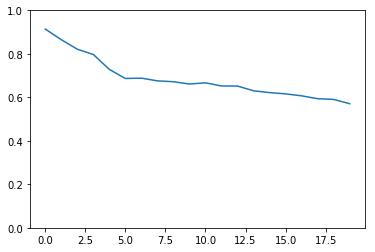

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.685495572787374


In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()